<a href="https://colab.research.google.com/github/saivignesh21/droplet-analysis/blob/main/10finalplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬆ Upload your 10cst5cm.zip file


Saving 10cst5cm.zip to 10cst5cm (1).zip


Processing 10cst5cm (1).zip: 100%|██████████| 203/203 [00:01<00:00, 147.57it/s]



✅ Saved results to results_10cst5cm (1).csv
Initial Diameter D0 = 10.91 mm
Maximum Diameter Dmax = 10.92 mm
Spreading Factor β = 1.001


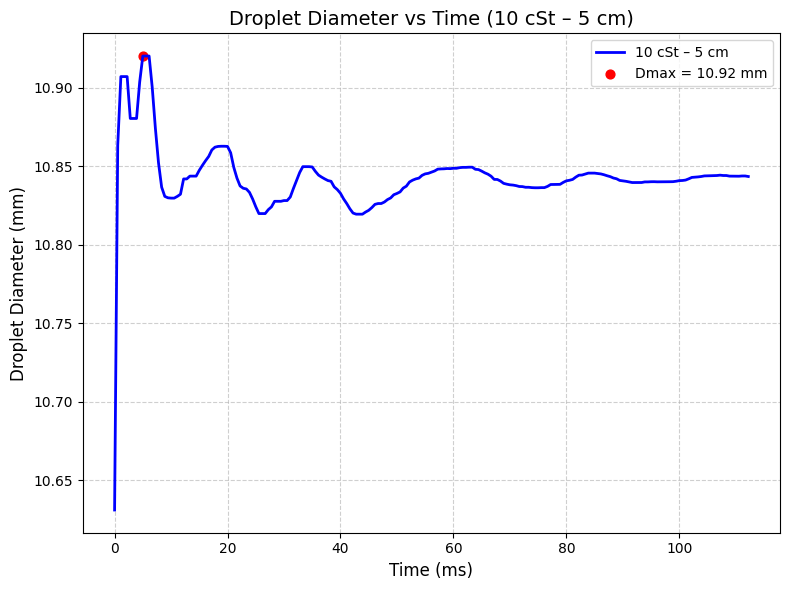

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload the single dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 10cst5cm.zip file")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙ Constants
# ==============================================================
FPS = 1800
time_per_frame = 1 / FPS
pixels_per_mm = 36.14        # ✅ updated calibration value from ImageJ
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    """Convert to grayscale if needed"""
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    """Extracts frames, detects droplet, computes diameter (mm) vs time"""
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- Optional crop (tune region if needed) ---
        roi = gray[500:800, :]  # adjust based on droplet location

        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i * time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2 * np.sqrt(area_px / np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel
        diam_mm.append(eq_d_mm)
        times.append(i * time_per_frame)

    # --- Fill missing frames + smooth ---
    diam = np.array(diam_mm, float)
    idx = np.arange(len(diam))
    if np.any(np.isnan(diam)):
        f = interp1d(idx[~np.isnan(diam)], diam[~np.isnan(diam)], fill_value="extrapolate")
        diam = f(idx)
    diam = medfilt(diam, 5)

    # --- Compute metrics ---
    t_ms = np.array(times) * 1000
    D0 = np.median(diam[:5])
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    Beta = Dmax / D0

    # --- Save CSV ---
    csv_name = f"results_{zip_path.replace('.zip', '.csv')}"
    pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam}).to_csv(csv_name, index=False)
    print(f"\n✅ Saved results to {csv_name}")
    print(f"Initial Diameter D0 = {D0:.2f} mm")
    print(f"Maximum Diameter Dmax = {Dmax:.2f} mm")
    print(f"Spreading Factor β = {Beta:.3f}")

    return t_ms, diam, Dmax, Tmax, D0, Beta

# ==============================================================
# 📊 STEP 4: Run for 10 cSt 5 cm
# ==============================================================
t_ms, diam_mm, Dmax, Tmax, D0, Beta = process_zip(zip_name)

plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label="10 cSt – 5 cm")
plt.scatter(Tmax, Dmax, color='r', s=40, label=f"Dmax = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title("Droplet Diameter vs Time (10 cSt – 5 cm)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

)



In [ ]:
from google.colab import files
files.download("results_10cst5cm (1).csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬆ Upload your 10cst10cm.zip file


Saving 10cst10cm.zip to 10cst10cm.zip


Processing 10cst10cm.zip: 100%|██████████| 323/323 [00:01<00:00, 201.87it/s]


✅ Data saved as 10cst10cm_processed.csv


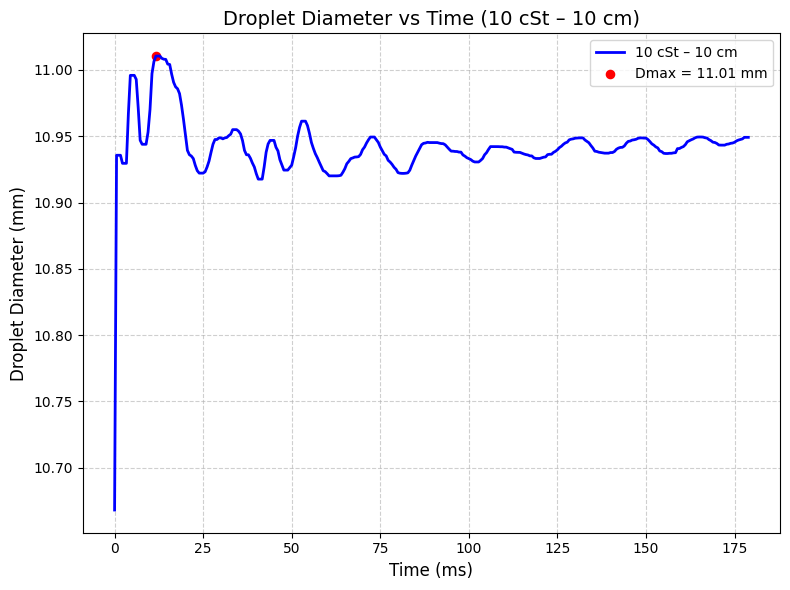

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 10cst10cm.zip file")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙️ Constants
# ==============================================================
FPS = 1800
time_per_frame = 1 / FPS
pixels_per_mm = 36.14     # calibration from ImageJ
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙️ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- Optional crop (tweak if droplet area differs) ---
        roi = gray[500:800, :]  # adjust if needed

        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i * time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2 * np.sqrt(area_px / np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel
        diam_mm.append(eq_d_mm)
        times.append(i * time_per_frame)

    # --- Fill NaNs + smooth ---
    diam = np.array(diam_mm, float)
    nans = np.isnan(diam)
    if np.any(nans):
        idx = np.arange(len(diam))
        f = interp1d(idx[~nans], diam[~nans], bounds_error=False, kind='linear')
        diam[nans] = f(idx[nans])
    diam = medfilt(diam, 5)

    t_ms = np.array(times) * 1000
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    return t_ms, diam, Dmax, Tmax

# ==============================================================
# 📊 STEP 4: Run for 10 cSt – 10 cm
# ==============================================================
t_ms, diam_mm, Dmax, Tmax = process_zip(zip_name)

# Save to CSV
df = pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam_mm})
csv_name = zip_name.replace('.zip', '_processed.csv')
df.to_csv(csv_name, index=False)
print(f"✅ Data saved as {csv_name}")

# Plot
plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label="10 cSt – 10 cm")
plt.scatter(Tmax, Dmax, color='r', s=35, label=f"Dmax = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title("Droplet Diameter vs Time (10 cSt – 10 cm)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
files.download("10cst10cm_processed.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬆ Upload your 10cst20cm.zip file


Saving 10cst20cm.zip to 10cst20cm.zip


Processing 10cst20cm.zip: 100%|██████████| 180/180 [00:00<00:00, 202.89it/s]


✅ Data saved as 10cst20cm_processed.csv


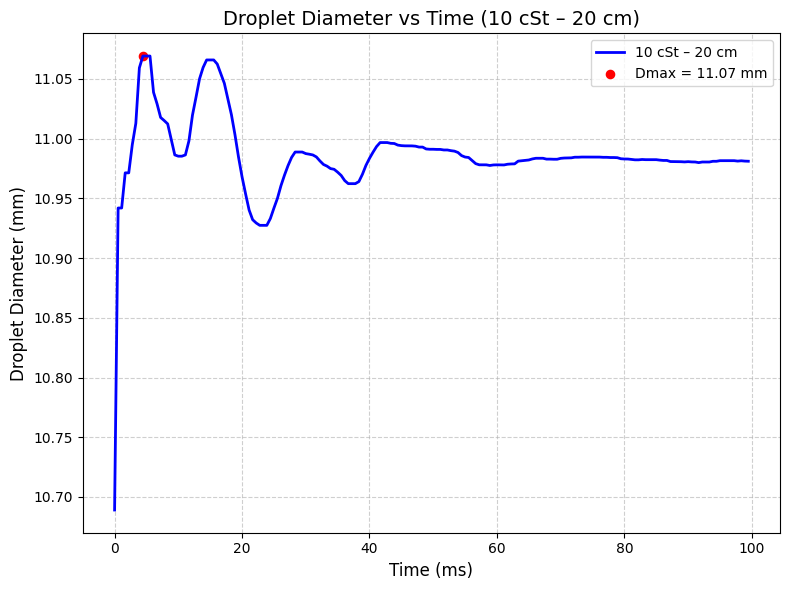

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 10cst20cm.zip file")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙️ Constants
# ==============================================================
FPS = 1800
time_per_frame = 1 / FPS
pixels_per_mm = 36.14    # calibration value from ImageJ
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙️ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- optional crop (focus on droplet area) ---
        roi = gray[500:800, :]  # adjust if needed

        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i*time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2*np.sqrt(area_px/np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel
        diam_mm.append(eq_d_mm)
        times.append(i*time_per_frame)

    # --- fill NaNs & smooth ---
    diam = np.array(diam_mm, float)
    nans = np.isnan(diam)
    if np.any(nans):
        idx = np.arange(len(diam))
        f = interp1d(idx[~nans], diam[~nans], bounds_error=False, kind='linear')
        diam[nans] = f(idx[nans])
    diam = medfilt(diam, 5)

    t_ms = np.array(times) * 1000
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    return t_ms, diam, Dmax, Tmax

# ==============================================================
# 📊 STEP 4: Run for 10 cSt – 20 cm
# ==============================================================
t_ms, diam_mm, Dmax, Tmax = process_zip(zip_name)

# Save to CSV
df = pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam_mm})
csv_name = zip_name.replace('.zip', '_processed.csv')
df.to_csv(csv_name, index=False)
print(f"✅ Data saved as {csv_name}")

# Plot
plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label="10 cSt – 20 cm")
plt.scatter(Tmax, Dmax, color='r', s=35, label=f"Dmax = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title("Droplet Diameter vs Time (10 cSt – 20 cm)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
files.download("10cst20cm_processed.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬆ Upload your 10cst30cm.zip file


Saving 10cst30cm.zip to 10cst30cm.zip


Processing 10cst30cm.zip: 100%|██████████| 152/152 [00:00<00:00, 193.89it/s]


✅ Data saved as 10cst30cm_processed.csv


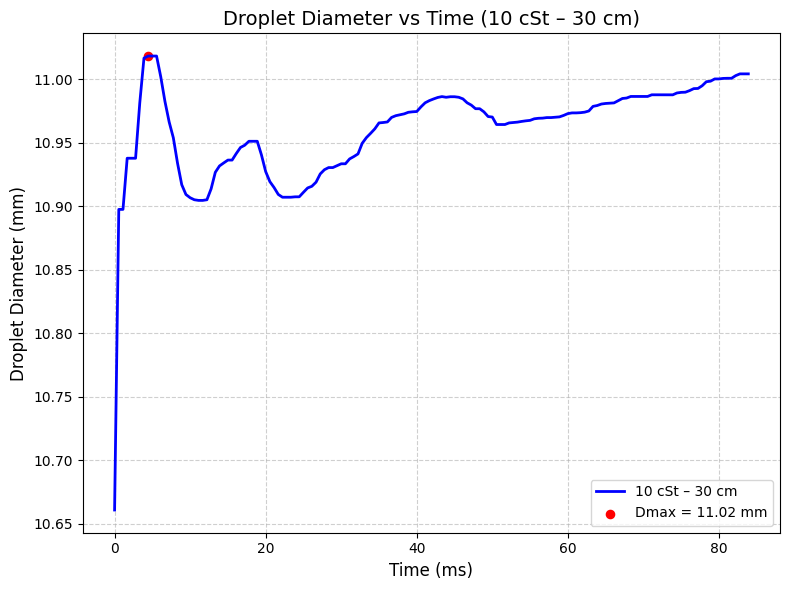

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import
# ==============================================================
!pip install opencv-python-headless scikit-image tqdm matplotlib --quiet

import os, zipfile, cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from scipy.signal import medfilt
from scipy.interpolate import interp1d
import pandas as pd

# ==============================================================
# 🗂 STEP 2: Upload Dataset
# ==============================================================
from google.colab import files
print("⬆ Upload your 10cst30cm.zip file")
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# ==============================================================
# ⚙️ Constants
# ==============================================================
FPS = 1800
time_per_frame = 1 / FPS
pixels_per_mm = 36.14    # calibration from ImageJ
mm_per_pixel = 1 / pixels_per_mm

# ==============================================================
# ⚙️ STEP 3: Droplet Processing Function
# ==============================================================
def ensure_gray(img):
    if len(img.shape) == 3:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def process_zip(zip_path):
    extract_folder = zip_path.replace('.zip','')
    os.makedirs(extract_folder, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_folder)

    frames = sorted([f for f in os.listdir(extract_folder) if f.lower().endswith('.tif')])
    if not frames:
        raise RuntimeError(f"No .tif files found in {zip_path}")

    diam_mm, times = [], []

    for i, fname in enumerate(tqdm(frames, desc=f"Processing {zip_path}")):
        img = io.imread(os.path.join(extract_folder, fname))
        gray = ensure_gray(img)

        # --- optional crop (focus on droplet area) ---
        roi = gray[500:800, :]  # adjust if droplet lower/higher

        blur = cv2.GaussianBlur(roi, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        if np.mean(roi[th==255]) > np.mean(roi[th==0]):
            th = cv2.bitwise_not(th)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel)

        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not cnts:
            diam_mm.append(np.nan)
            times.append(i*time_per_frame)
            continue

        c = max(cnts, key=cv2.contourArea)
        area_px = cv2.contourArea(c)
        eq_d_px = 2*np.sqrt(area_px/np.pi)
        eq_d_mm = eq_d_px * mm_per_pixel
        diam_mm.append(eq_d_mm)
        times.append(i*time_per_frame)

    # --- fill NaNs & smooth ---
    diam = np.array(diam_mm, float)
    nans = np.isnan(diam)
    if np.any(nans):
        idx = np.arange(len(diam))
        f = interp1d(idx[~nans], diam[~nans], bounds_error=False, kind='linear')
        diam[nans] = f(idx[nans])
    diam = medfilt(diam, 5)

    t_ms = np.array(times) * 1000
    Dmax = np.nanmax(diam)
    Tmax = t_ms[np.argmax(diam)]
    return t_ms, diam, Dmax, Tmax

# ==============================================================
# 📊 STEP 4: Run for 10 cSt – 30 cm
# ==============================================================
t_ms, diam_mm, Dmax, Tmax = process_zip(zip_name)

# Save to CSV
df = pd.DataFrame({"Time_ms": t_ms, "Diameter_mm": diam_mm})
csv_name = zip_name.replace('.zip', '_processed.csv')
df.to_csv(csv_name, index=False)
print(f"✅ Data saved as {csv_name}")

# Plot
plt.figure(figsize=(8,6))
plt.plot(t_ms, diam_mm, 'b-', linewidth=2, label="10 cSt – 30 cm")
plt.scatter(Tmax, Dmax, color='r', s=35, label=f"Dmax = {Dmax:.2f} mm")
plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title("Droplet Diameter vs Time (10 cSt – 30 cm)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
files.download("10cst30cm_processed.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬆ Upload your 4 processed CSV files (5cm, 10cm, 20cm, 30cm)


Saving 10cst30cm_processed.csv to 10cst30cm_processed (1).csv
Saving 10cst20cm_processed.csv to 10cst20cm_processed (1).csv
Saving 10cst10cm_processed.csv to 10cst10cm_processed (1).csv
Saving 10cst5cm_processed.csv to 10cst5cm_processed.csv


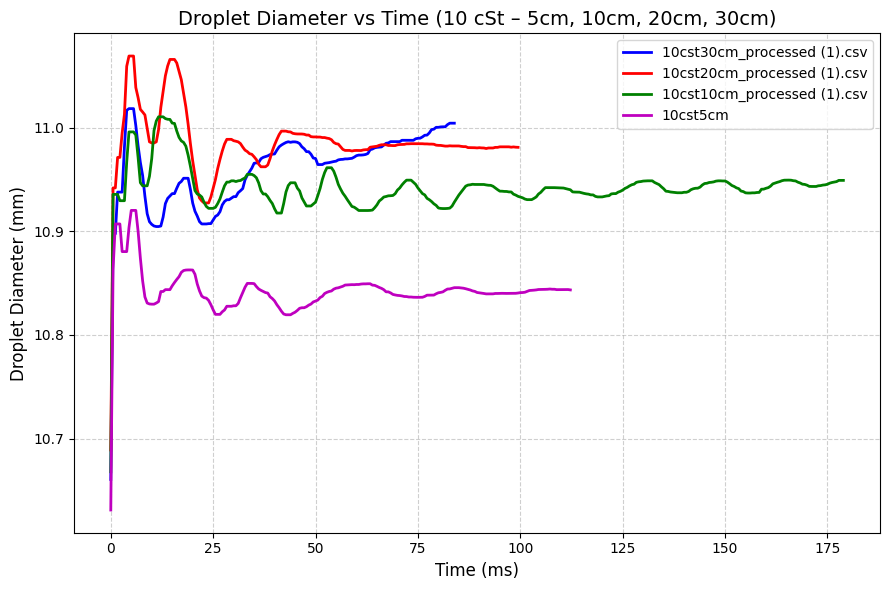

In [ ]:
# ==============================================================
# 📊 Compare 10 cSt droplet impact at four heights
# ==============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ---- Upload all 4 CSVs ----
from google.colab import files
print("⬆ Upload your 4 processed CSV files (5cm, 10cm, 20cm, 30cm)")
uploaded = files.upload()

# ---- Read all into a dictionary ----
datasets = {}
for name in uploaded.keys():
    df = pd.read_csv(name)
    datasets[name.replace('_processed.csv','')] = df

# ---- Plot all together ----
plt.figure(figsize=(9,6))

colors = ['b', 'r', 'g', 'm']
for (label, color) in zip(datasets.keys(), colors):
    df = datasets[label]
    plt.plot(df["Time_ms"], df["Diameter_mm"], color=color, linewidth=2, label=label)

plt.xlabel("Time (ms)", fontsize=12)
plt.ylabel("Droplet Diameter (mm)", fontsize=12)
plt.title("Droplet Diameter vs Time (10 cSt – 5cm, 10cm, 20cm, 30cm)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


⬆ Upload your 4 CSVs: 10cst5cm_processed, 10cst10cm_processed, 10cst20cm_processed, 10cst30cm_processed


Saving 10cst30cm_processed.csv to 10cst30cm_processed (2).csv
Saving 10cst20cm_processed.csv to 10cst20cm_processed (2).csv
Saving 10cst10cm_processed.csv to 10cst10cm_processed (2).csv
Saving 10cst5cm_processed.csv to 10cst5cm_processed (1).csv


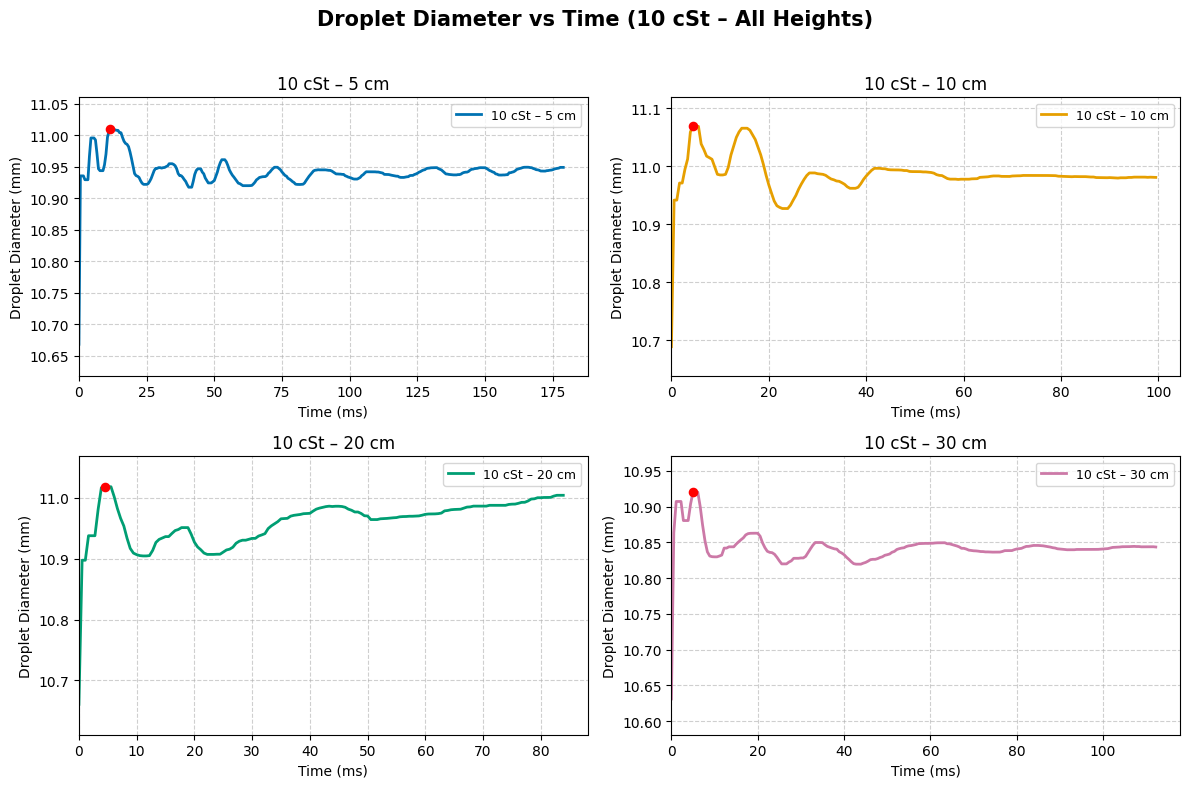

In [ ]:
# ==============================================================
# 📊 Combined Plot: Droplet Diameter vs Time (10 cSt – 5cm, 10cm, 20cm, 30cm)
# ==============================================================

import pandas as pd
import matplotlib.pyplot as plt

# ---- Upload your 4 processed CSV files ----
from google.colab import files
print("⬆ Upload your 4 CSVs: 10cst5cm_processed, 10cst10cm_processed, 10cst20cm_processed, 10cst30cm_processed")
uploaded = files.upload()

# ---- Load data into dictionary ----
data = {}
for name in uploaded.keys():
    df = pd.read_csv(name)
    data[name.replace('.csv', '')] = df

# ---- Plot setup ----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

titles = ['10 cSt – 5 cm', '10 cSt – 10 cm', '10 cSt – 20 cm', '10 cSt – 30 cm']
colors = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']  # better color palette

# ---- Iterate through datasets ----
for ax, title, color, key in zip(axes, titles, colors, sorted(data.keys())):
    df = data[key]
    t_ms = df["Time_ms"]
    D = df["Diameter_mm"]
    Dmax = D.max()
    Tmax = t_ms[D.idxmax()]

    ax.plot(t_ms, D, color=color, linewidth=2, label=title)
    ax.scatter(Tmax, Dmax, color='red', s=35, zorder=3)
    ax.set_xlabel("Time (ms)", fontsize=10)
    ax.set_ylabel("Droplet Diameter (mm)", fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=9)
    ax.set_xlim([0, max(t_ms)*1.05])
    ax.set_ylim([min(D)-0.05, max(D)+0.05])

# ---- Main title ----
plt.suptitle("Droplet Diameter vs Time (10 cSt – All Heights)", fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


⬆ Upload your 4 processed CSVs (10cst5cm_processed.csv, 10cst10cm_processed.csv, 10cst20cm_processed.csv, 10cst30cm_processed.csv)


Saving 10cst30cm_processed.csv to 10cst30cm_processed (3).csv
Saving 10cst20cm_processed.csv to 10cst20cm_processed (3).csv
Saving 10cst10cm_processed.csv to 10cst10cm_processed (3).csv
Saving 10cst5cm_processed.csv to 10cst5cm_processed (2).csv


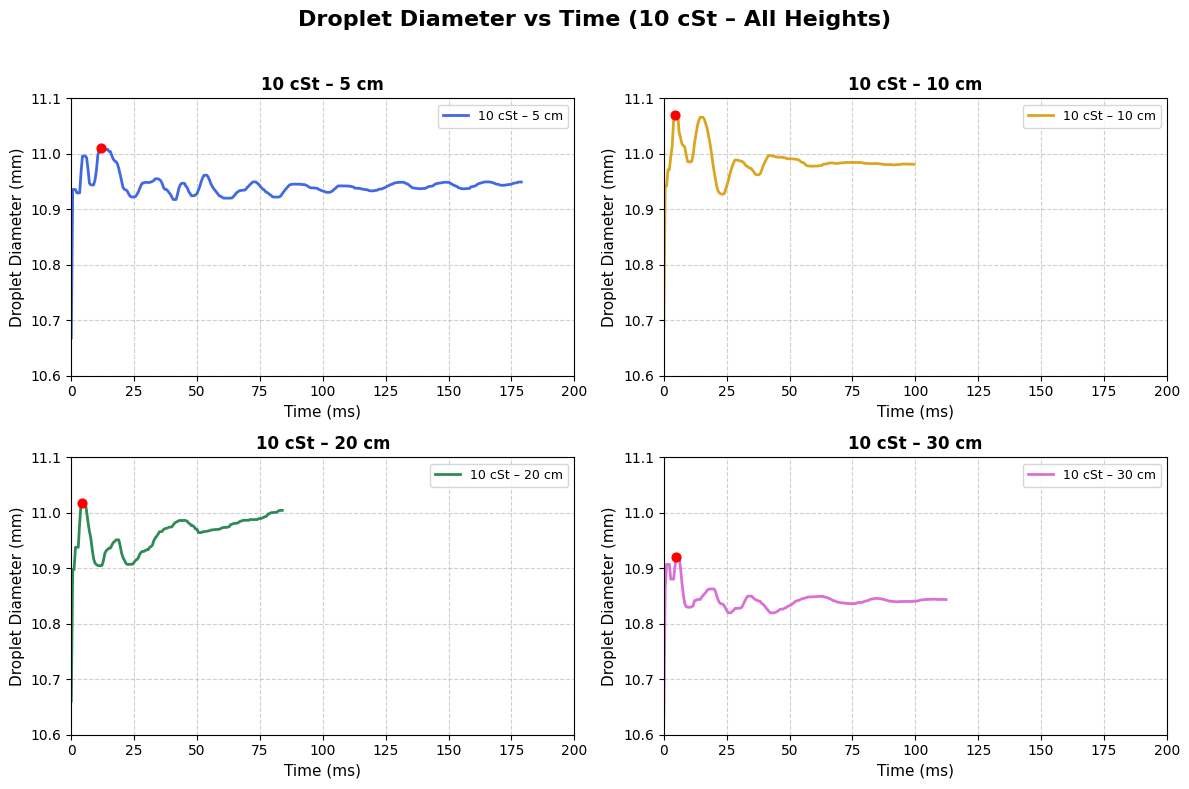

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import
# ==============================================================
!pip install matplotlib pandas --quiet

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================
# 🗂 STEP 2: Upload your 4 CSVs (5 cm, 10 cm, 20 cm, 30 cm)
# ==============================================================
from google.colab import files
print("⬆ Upload your 4 processed CSVs (10cst5cm_processed.csv, 10cst10cm_processed.csv, 10cst20cm_processed.csv, 10cst30cm_processed.csv)")
uploaded = files.upload()

# ==============================================================
# ⚙️ STEP 3: Read all CSVs
# ==============================================================
data = {}
for name in uploaded.keys():
    df = pd.read_csv(name)
    data[name.replace(".csv", "")] = df

# ==============================================================
# 🎨 STEP 4: Plot all 4 (2×2 grid)
# ==============================================================
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

titles = [
    "10 cSt – 5 cm",
    "10 cSt – 10 cm",
    "10 cSt – 20 cm",
    "10 cSt – 30 cm"
]

colors = ["royalblue", "goldenrod", "seagreen", "orchid"]

# Common y-limits for visual consistency
y_min, y_max = 10.6, 11.1

for ax, (title, color, key) in zip(axes, zip(titles, colors, sorted(data.keys()))):
    df = data[key]
    t_ms = df["Time_ms"]
    D = df["Diameter_mm"]
    Dmax = D.max()
    Tmax = t_ms[D.idxmax()]

    ax.plot(t_ms, D, color=color, linewidth=2, label=title)
    ax.scatter(Tmax, Dmax, color='red', s=40, zorder=3)
    ax.set_xlabel("Time (ms)", fontsize=11)
    ax.set_ylabel("Droplet Diameter (mm)", fontsize=11)
    ax.set_title(title, fontsize=12, weight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)

    # Uniform x & y limits across all
    ax.set_xlim(0, 200)
    ax.set_ylim(y_min, y_max)

# ==============================================================
# 🖼 STEP 5: Final styling
# ==============================================================
plt.suptitle("Droplet Diameter vs Time (10 cSt – All Heights)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


⬆ Upload your processed CSVs (10cst5cm_processed, 10cst10cm_processed, 10cst20cm_processed, 10cst30cm_processed)


Saving 10cst30cm_processed.csv to 10cst30cm_processed (4).csv
Saving 10cst20cm_processed.csv to 10cst20cm_processed (4).csv
Saving 10cst10cm_processed.csv to 10cst10cm_processed (4).csv
Saving 10cst5cm_processed.csv to 10cst5cm_processed (3).csv


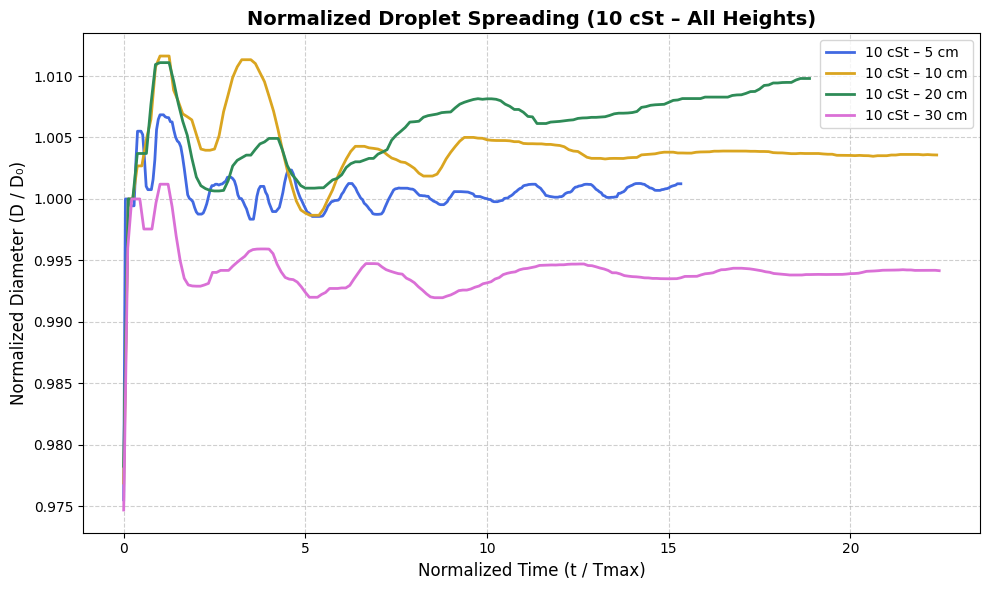

In [ ]:
# ==============================================================
# 🧩 STEP 1: Install & Import
# ==============================================================
!pip install pandas matplotlib --quiet
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# ==============================================================
# 🗂 STEP 2: Upload the 4 CSV files
# ==============================================================
print("⬆ Upload your processed CSVs (10cst5cm_processed, 10cst10cm_processed, 10cst20cm_processed, 10cst30cm_processed)")
uploaded = files.upload()

# ==============================================================
# ⚙ STEP 3: Load and Normalize
# ==============================================================
data = {}
for name in uploaded.keys():
    df = pd.read_csv(name)
    D = df["Diameter_mm"]
    t = df["Time_ms"]

    # Compute D0 (initial) and Dmax (max spread)
    D0 = D.iloc[:5].median()  # average of first few stable frames
    Dmax = D.max()
    Tmax = t[D.idxmax()]

    # Normalize diameter and time
    df["D_norm"] = D / D0
    df["t_norm"] = t / Tmax

    data[name.replace(".csv", "")] = df

# ==============================================================
# 📊 STEP 4: Plot normalized curves
# ==============================================================
plt.figure(figsize=(10,6))

colors = ["royalblue", "goldenrod", "seagreen", "orchid"]
titles = ["10 cSt – 5 cm", "10 cSt – 10 cm", "10 cSt – 20 cm", "10 cSt – 30 cm"]

for color, title, key in zip(colors, titles, sorted(data.keys())):
    df = data[key]
    plt.plot(df["t_norm"], df["D_norm"], color=color, linewidth=2, label=title)

plt.xlabel("Normalized Time (t / Tmax)", fontsize=12)
plt.ylabel("Normalized Diameter (D / D₀)", fontsize=12)
plt.title("Normalized Droplet Spreading (10 cSt – All Heights)", fontsize=14, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
